In [ ]:
import glob 
import uproot
import awkward as ak 
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


def get_time_residuals(filelist,threshold=60):
    # Things we really care about
    all_tres = []
    all_amps = []
    # For debugging tres
    all_raw = []
    all_trigs = []

    for file in tqdm(filelist):
        n_tup = uproot.open(file)
        meta = n_tup["meta;1"]
        # print(meta.keys())

        meta_info = meta.arrays(meta.keys(),library = "ak")
        # print(meta_info['const_frac_threshold'])
        output = n_tup["output"]
        # print(output.keys())
        event_info = output.arrays(output.keys(),library = "ak")

        lcns = event_info['lcns']
        waveforms = event_info['waveforms']
        # print(lcns[0])
        # print(waveforms[0])

        n=100


        tres = []
        raw = []
        trigs = []
        amps = []

        for i in range(len(waveforms[:n])):
            evtgroup0 = []
            evtgroup1 = []
            evtgroup2 = []
            evtgroup3 = []
            evttrig = []
            for j in range(len(waveforms[i])):
                if (lcns[i][j]<31):
                    ped = ak.mean(waveforms[i][j][500:900])
                    wf = waveforms[i][j][10:-10]
                    amp = ak.max(wf-ped)
                    amps.append(amp)
                    if amp>threshold:
                        crossed = wf-ped > (0.6*(ak.max(wf)-ped)) 
                        above = ak.where(crossed)[0]
                        # Need to add interpolation to get better time
                        if len(above)>0:
                            if (lcns[i][j]<8):
                                evtgroup0.append(0.2*above[0])
                            if (7<lcns[i][j]<16):
                                evtgroup1.append(0.2*above[0])
                            if (15<lcns[i][j]<24):
                                evtgroup2.append(0.2*above[0])
                            if (23<lcns[i][j]<31): # 31 is coincident pmt trigger
                                evtgroup3.append(0.2*above[0])
                elif (lcns[i][j]>31): # trigger pmts 32,48,64,80
                    ped = ak.mean(waveforms[i][j][100:500])
                    wf = waveforms[i][j][100:-100]
                    amp = ak.max(wf-ped)
                    if amp>threshold:
                        crossed = wf-ped > (0.6*(ak.max(wf)-ped)) 
                        above = ak.where(crossed)[0]
                        if len(above)>0:
                            evttrig.append(0.2*above[0])

            if len(evttrig)==4:
                for t in evttrig:
                    trigs.append(t)
                for t in evtgroup0:
                    tres.append(t-evttrig[0])
                    raw.append(t)
                for t in evtgroup1:
                    tres.append(t-evttrig[1])
                    raw.append(t)
                for t in evtgroup2:
                    tres.append(t-evttrig[2])
                    raw.append(t)
                for t in evtgroup3:
                    tres.append(t-evttrig[3])
                    raw.append(t)
        all_tres.extend(tres)
        all_raw.extend(raw)
        all_trigs.extend(trigs)
        all_amps.extend(amps)
    return np.array(all_tres), np.array(all_amps), np.array(all_raw), np.array(all_trigs)

In [103]:
threshold = 55

In [104]:
water_data = get_time_residuals(glob.glob("processed/water/*.root"),threshold)
water_tres = water_data[0]
water_hit_amplitudes = water_data[1]
water_raw_hit_times = water_data[2]
water_trigger_times = water_data[3]


100%|██████████| 6/6 [00:29<00:00,  4.93s/it]


In [105]:
labppo_data = get_time_residuals(glob.glob("processed/labppo/*.root"),threshold)
labppo_tres = labppo_data[0]
labppo_hit_amplitudes = labppo_data[1] 
labppo_raw_hit_times = labppo_data[2] 
labppo_trigger_times = labppo_data[3]

100%|██████████| 4/4 [00:19<00:00,  4.77s/it]


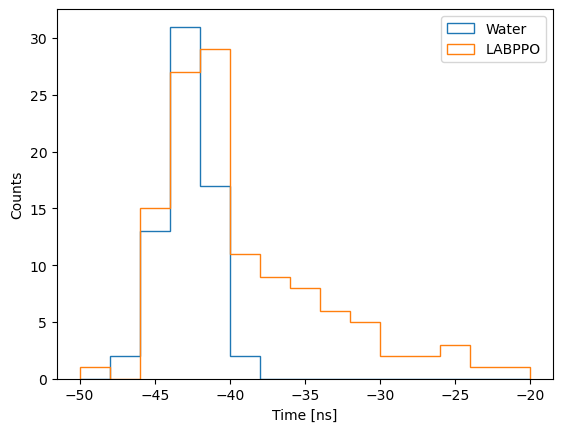

In [120]:
plt.plot(figsize=(10,5))

dt = 2
bin_edges = np.arange(-50, -20 + dt, dt)  # 0.0, 0.2, ..., 100.0

plt.hist(water_tres,bins=bin_edges,histtype='step',label='Water',density=False);
plt.hist(labppo_tres,bins=bin_edges,histtype='step',label='LABPPO',density=False);
plt.xlabel('Time [ns]')
plt.ylabel("Counts")
plt.legend();

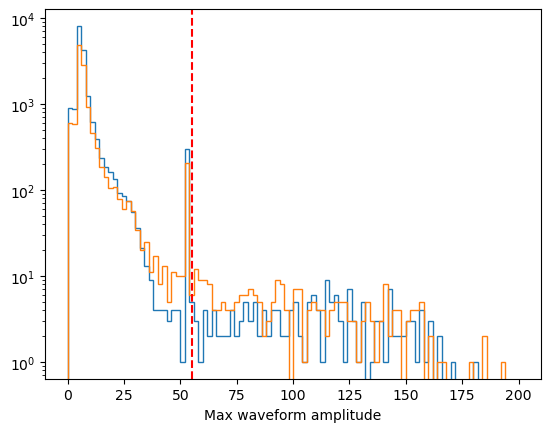

In [107]:

plt.hist(water_hit_amplitudes,bins=100,range=(0,200),histtype='step')
plt.hist(labppo_hit_amplitudes,bins=100,range=(0,200),histtype='step')
plt.yscale('log')
plt.xlabel('Max waveform amplitude')
plt.axvline(threshold,color='red',linestyle='--')

In [98]:
print(event_info['times'])

[[92.1, 205, 111, 112, 131, 130, ..., -inf, 68.2, 90.3, 90.5, 89.7, 89.9], ...]


In [6]:
# testing